# Loan Default Prediction
## Team Members:
* Harish Puvvada         - hp1047
* Vamsi Mohan Ramineedi  - vmr286

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

<p>
<span style="color:blue">
 Importing data of Lending club for the years 2012-14
</span>
</p>

In [2]:
df2012_13 = pd.read_csv(os.getenv('FDS')+'LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv(os.getenv('FDS')+'LoanStats_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

In [3]:
dataset = pd.concat([df2012_13, df2014]) #merging 2007 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [4]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (376233, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,27050.0,27050.0,27050.0,36 months,10.99%,885.46,B,B2,Team Leadern Customer Ops & Systems,10+ years,OWN,55000.0,Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Combining high ...,debt_consolidation,Debt Consolidation,481xx,MI,22.87,0.0,Oct-1986,0.0,NaN,NaN,14.0,0.0,36638.0,61.2%,27.0,w,0.0,0.0,31752.530000,...,3.0,9570.0,16473.0,53.9,0.0,0.0,117.0,326.0,16.0,6.0,4.0,16.0,NaN,8.0,NaN,0.0,2.0,4.0,4.0,8.0,8.0,10.0,15.0,4.0,14.0,0.0,0.0,0.0,1.0,100.0,25.0,0.0,0.0,138554.0,70186.0,35700.0,33054.0
1,12000.0,12000.0,12000.0,36 months,10.99%,392.81,B,B2,Project Manager,4 years,RENT,60000.0,Not Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > I would like to...,debt_consolidation,No Regrets,281xx,NC,4.62,0.0,Dec-2009,1.0,NaN,NaN,15.0,0.0,7137.0,24%,18.0,f,0.0,0.0,13988.609996,...,8.0,476.0,15216.0,15.9,0.0,0.0,NaN,48.0,1.0,1.0,0.0,1.0,NaN,3.0,NaN,0.0,4.0,7.0,8.0,10.0,0.0,15.0,18.0,7.0,15.0,0.0,0.0,0.0,4.0,100.0,0.0,0.0,0.0,29700.0,7137.0,18100.0,0.0
2,4800.0,4800.0,4800.0,36 months,10.99%,157.13,B,B2,Surgical Technician,2 years,MORTGAGE,39600.0,Source Verified,Dec-2013,0,n,NaN,Borrower added on 12/31/13 > Just bought a h...,home_improvement,For The House,782xx,TX,2.49,0.0,Aug-1995,2.0,NaN,NaN,3.0,0.0,4136.0,16.1%,8.0,w,0.0,0.0,5157.519457,...,0.0,1379.0,21564.0,16.1,0.0,0.0,104.0,220.0,25.0,25.0,0.0,25.0,NaN,3.0,NaN,0.0,2.0,2.0,3.0,4.0,1.0,3.0,7.0,2.0,3.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,25700.0,4136.0,25700.0,0.0


In [5]:
#print(Dataset_withBoolTarget.shape)
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
#print(x.isnull().sum()) #- to check how many null values in all the columns
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 74)


In [6]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (376233, 52)


In [7]:
#features = ['funded_amnt','last_pymnt_amnt','int_rate','loan_status']

features = ['funded_amnt','emp_length','annual_inc', 'last_pymnt_amnt',
            "mort_acc", "int_rate",
            "mo_sin_old_rev_tl_op",
           "avg_cur_bal","acc_open_past_24mths", 'num_sats','loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',

Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 11)


## Data Transformation


In [8]:
#Data encoding
#Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
#Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (376233, 11)


,funded_amnt,emp_length,annual_inc,last_pymnt_amnt,mort_acc,int_rate,mo_sin_old_rev_tl_op,avg_cur_bal,acc_open_past_24mths,num_sats,loan_status
0,27050.0,10,55000.0,6074.19,4.0,10.99,326.0,9570.0,3.0,14.0,0
1,12000.0,4,60000.0,3775.55,0.0,10.99,48.0,476.0,8.0,15.0,0
2,4800.0,2,39600.0,3900.48,0.0,10.99,220.0,1379.0,0.0,3.0,0
3,12000.0,10,130000.0,398.28,3.0,11.99,193.0,36362.0,4.0,9.0,0
4,7550.0,3,28000.0,529.67,0.0,16.24,38.0,1440.0,1.0,4.0,0


In [9]:
#Final_data[Final_data['loan_status']==0]["last_pymnt_amnt"].value_counts()

## Filling Missing values and Feature scaling 


In [10]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (376233, 11)


In [11]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1] 
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    310035
1     66198
Name: loan_status, dtype: int64

In [12]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (11000, 11)


,funded_amnt,emp_length,annual_inc,last_pymnt_amnt,mort_acc,int_rate,mo_sin_old_rev_tl_op,avg_cur_bal,acc_open_past_24mths,num_sats,loan_status
0,0.250205,1.140751,-0.150887,-0.680127,-0.840272,1.010133,0.701625,-3.508140e-01,-1.529662,-1.300465e+00,1
1,0.713872,1.140751,-0.002827,-0.619230,-0.840272,2.553757,1.963141,-6.321542e-01,-0.806951,5.482251e-01,1
2,0.103784,0.592149,-0.521036,-0.681369,-0.840272,1.639017,0.770435,-1.688686e-01,-0.084239,5.482251e-01,1
3,0.713872,1.140751,-0.021335,-0.637541,-0.840272,-0.034958,0.000000,-1.169458e-16,-1.168306,3.648815e-16,1
4,-0.735087,0.043547,-0.798648,-0.109542,-0.840272,0.856914,-0.341993,-6.862235e-01,-0.084239,-4.788251e-01,0


<p>
<span style="color:blue">
Below are correlation values between the features finally selected.
</span>
</p>

In [13]:
data_clean.corr()

,funded_amnt,emp_length,annual_inc,last_pymnt_amnt,mort_acc,int_rate,mo_sin_old_rev_tl_op,avg_cur_bal,acc_open_past_24mths,num_sats,loan_status
funded_amnt,1.000000,0.136318,0.455994,0.318836,0.223047,0.168225,0.171970,0.251614,0.011502,0.198116,0.086968
emp_length,0.136318,1.000000,0.115005,0.046819,0.159170,0.023545,0.121298,0.091846,0.028251,0.063989,-0.002186
annual_inc,0.455994,0.115005,1.000000,0.197831,0.289853,-0.057178,0.194911,0.422852,0.040290,0.170199,-0.086474
last_pymnt_amnt,0.318836,0.046819,0.197831,1.000000,0.139882,-0.011171,0.072774,0.148240,-0.008443,0.048677,-0.476163
mort_acc,0.223047,0.159170,0.289853,0.139882,1.000000,-0.079954,0.281658,0.424912,0.038186,0.092465,-0.070682
int_rate,0.168225,0.023545,-0.057178,-0.011171,-0.079954,1.000000,-0.117281,-0.088175,0.176437,-0.003792,0.312620
mo_sin_old_rev_tl_op,0.171970,0.121298,0.194911,0.072774,0.281658,-0.117281,1.000000,0.130133,-0.066387,0.116357,-0.062037
avg_cur_bal,0.251614,0.091846,0.422852,0.148240,0.424912,-0.088175,0.130133,1.000000,-0.088866,-0.093151,-0.088686
acc_open_past_24mths,0.011502,0.028251,0.040290,-0.008443,0.038186,0.176437,-0.066387,-0.088866,1.000000,0.462410,0.112562
num_sats,0.198116,0.063989,0.170199,0.048677,0.092465,-0.003792,0.116357,-0.093151,0.462410,1.000000,0.036402


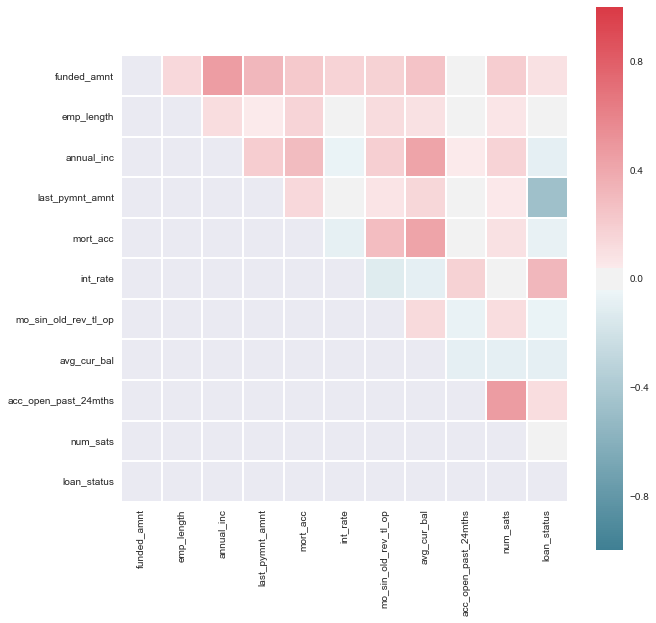

In [14]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

## Learning Curve

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

In [ ]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# np.random.seed(0)
# data_clean_20000 = np.random.randint(0,data_clean.shape[0], size=20000)
# X = data_clean.iloc[data_clean_20000,:-1].values
# y = data_clean.iloc[data_clean_20000,-1].values

## Algorithms


## Random Forest


In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.33, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.33, random_state=42) #just for bootstrapping

### GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    return mean_scores,grid.best_score_,grid.best_estimator_
    
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_grid = dict(max_features=maxFeatures,min_samples_split=min_samples_split_values,min_samples_leaf=min_samples_leaf_values)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(rf,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
Best_classifier

### Randomized Search CV

In [ ]:
from sklearn.grid_search import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

In [ ]:
plt.plot(maxFeatures,mean_scores)
plt.title(' Accuracy vs Number of Features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')

In [ ]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

In [ ]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(fields)), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

## ROC-AUC curve plot function


In [ ]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression


In [ ]:
logreg = linear_model.LogisticRegression(random_state=0)
c=[1e30] ## This has to be changed - vamsi
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)
plt.plot(c,mean_scores)
plt.xlabel('C values')
plt.ylabel('Accuracy')

In [ ]:
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM)


In [ ]:
# from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
# clf_svm = svm.SVC()
# powers = range(0,5)
# cs = [10**i for i in powers]
# param_grid = dict(C=cs)
# grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
# grid.fit(data_clean.iloc[:,[0,2,4,6]].values, data_clean.iloc[:,-1].values)
# print("fitting done")
# grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
# print(grid_mean_scores)
# plt.plot(cs, grid_mean_scores)
# plt.xlabel('Value of K for SVM')
# plt.ylabel('Cross-Validated Accuracy')
# print("---------------")
# print(grid.best_score_)
# print("--------------")
# print(grid.best_params_)
# print("---------------")
# print(grid.best_estimator_)

In [ ]:
clf_svm = svm.SVC(kernel = "rbf", C=10000)
clf_svm.fit(X_train.iloc[:,[0,2,4,6]],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,[0,2,4,6]])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,[0,2,4,6]])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbours(KNN) with Grid Search and cross validation

In [ ]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
print("fitting done")
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid_mean_scores)
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
print("---------------")
print(grid.best_score_)
print("--------------")
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

In [ ]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
#plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

## Bootstrapping to find errors

In [27]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target,1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target,1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

LR -------
SVM -------
RF -------
KNN -------
250
LR -------
SVM -------
RF -------
KNN -------
1000
LR -------
SVM -------
RF -------
KNN -------
1500
LR -------
SVM -------
RF -------
KNN -------
2000
LR -------
SVM -------
RF -------
KNN -------
2750
LR -------
SVM -------
RF -------
KNN -------
3750
LR -------
SVM -------
RF -------
KNN -------
4500
LR -------
SVM -------
RF -------
KNN -------
5200
LR -------
SVM -------
RF -------
KNN -------
6500
LR -------
SVM -------
RF -------
KNN -------
7000
LR -------
SVM -------
RF -------
KNN -------
8000
LR -------
SVM -------
RF -------
KNN -------
8500
LR -------
SVM -------
RF -------
KNN -------
9000
LR -------
SVM -------
RF -------
KNN -------
10000
LR -------
SVM -------
RF -------
KNN -------
11000


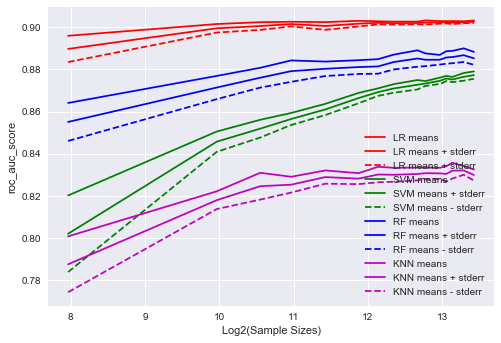

In [30]:
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset

LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-' , label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(loc = 'lower right')
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')

## Bagging for Classification

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

In [ ]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
#num_trees = 100
model = BaggingClassifier(base_estimator=clf_LR, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

## Ada Boost classifier

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

### Multi-Layer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
#plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

## Precision,recall,F1score for all algorithms

In [ ]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))
#print("Bagging",classification_report(y_true, y_pred, target_names=None))
#print("Ada Boost",classification_report(y_true, y_pred, target_names=None))

### Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained_variance = pca.explained_variance_ratio_
print(explained_variance)
#print('Expected Variance is '+ str(explained_variance))

In [ ]:
rfPca = RandomForestClassifier(criterion='gini', random_state=0)
rfPca.fit(X_train_pca,y_train)

In [ ]:
rfPcaPred = rfPca.predict(X_test_pca)
rfPca_accuracy = accuracy_score(y_test,rfPcaPred)
print(rfPca_accuracy)

In [ ]:
logregPCA = linear_model.LogisticRegression(C=1e30, random_state=0)
logregPCA.fit(X_train_pca,y_train)
logregPCA_pred = logregPCA.predict(X_test_pca)
logregPCA_accuracy = accuracy_score(y_test,logregPCA_pred)
print(logregPCA_accuracy)

### RFE

In [ ]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
rfe = RFE(clf_LR, 3)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

## Things to be done

In [ ]:
Important... 
### bagging, boosting - inference??? plots? conf matrix??? other alogs?

Final Submission...
### report - Prob moti, target var and features defined, motivation for each model, eval approaches, assumption and limitations
### mention about how the feature last payment is showing too much improvement in accuracy
### use online websites description for expalinaing algorithms
### Final IPynb with clear comments and explaination above the cells.
### Github Read me edit for your own sake